<a href="https://colab.research.google.com/github/utkarsh8273/MEMES_VS_NOTES/blob/master/Memes_Vs_Notes(without_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
import cv2

In [21]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [22]:
path_meme = glob.glob('/content/gdrive/My Drive/Stage_2/Memes/*.jpg')
path_notes = glob.glob('/content/gdrive/My Drive/Stage_2/Notes/*.jpg')
X_train = np.zeros((12288,1000))
Y_train = np.zeros((1,1000))
X_val = np.zeros((12288,300))
Y_val = np.zeros((1,300))
X_test = np.zeros((12288,300))
Y_test = np.zeros((1,300))
k = 0
for i in path_meme :
  img = cv2.imread(i)
  img = np.array(cv2.resize(img,(64,64)))
  img = img.reshape(-1)
  if k<500 :
    X_train[:,k] = np.copy(img)
    Y_train[:,k] = 1
  elif k >= 500 and k < 650:
    X_val[:,k-500] = np.copy(img)
    Y_val[:,k-500] = 1
  elif k >= 650 and k < 800 :
    X_test[:,k-650] = np.copy(img)
    Y_test[:,k-650] = 1
  else :
    break
  k = k + 1
  print(k)
k = 500
for i in path_notes :
  img = cv2.imread(i)
  img = np.array(cv2.resize(img,(64,64)))
  img = img.reshape(-1)
  if k<1000 :
    X_train[:,k] = np.copy(img)
    Y_train[:,k] = 0
  elif k>=1000 and k<1150 :
    X_val[:,k-850] = np.copy(img)
    Y_val[:,k-850] = 0
  elif k >= 1150 and k < 1300 :
    X_test[:,k-1000] = np.copy(img)
    Y_test[:,k-1000] = 0
  k = k + 1
  print(k)
print(X_val.shape)
print(Y_val.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
shuffle_index = np.random.permutation(X_train.shape[1])
X_train,Y_train = X_train[:,shuffle_index] , Y_train[:,shuffle_index]

In [23]:
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
n = X_train.shape[0]
m = X_train.shape[1]
print(n)
print(m)
def sigmoid(z) :
  return (1/(1+np.exp(-z)))
def relu(X) :
  X[X<0]=0
  return X

12288
1000


In [24]:
def initialize_wts(struct) :
  W = {}
  b = {}
  for i in range(1,len(struct)) :
    W["W" + str(i)] = np.random.randn(struct[i],struct[i-1])*np.sqrt(2/struct[i-1])
    b["b" + str(i)] = np.zeros((struct[i],1))
  return W,b
def forward_prop(X_train,W,b) :
  return relu(np.dot(W,X_train) + b)

In [25]:
def model(struct,X_train,Y_train,lr,num_itr,W,b,vdw,vdb) :
  beta = 0.9
  n = X_train.shape[0]
  m = X_train.shape[1]
  for k in range(0,num_itr) :
    A = {}
    A["A" + str(0)] = X_train
    for i in range(1,len(struct)-1) :
      A["A" + str(i)] = forward_prop(A["A" + str(i-1)],W["W" + str(i)],b["b" + str(i)])
    A["A" + str(len(struct) - 1)] = sigmoid(np.dot(W["W" + str(len(struct) - 1)] , A["A" + str(len(struct) - 2)]) + b["b" + str(len(struct) - 1)])
    dW = {}
    db = {}
    dZ = {}
    dZ["dZ" + str(len(struct) - 1)] = A["A" + str(len(struct) - 1)] - Y_train
    dW["dW" + str(len(struct) - 1)] = (1/m)*(np.dot(dZ["dZ" + str(len(struct) - 1)],A["A" + str(len(struct) - 2)].T))
    db["db" + str(len(struct) - 1)] = (1/m)*(np.sum(dZ["dZ" + str(len(struct) - 1)],axis = 1, keepdims = True))
    for i in range(0,len(W) - 1) :
      dZ["dZ" + str(len(W) - 1 - i)] = np.dot(W["W" + str(len(W) - i)].T,dZ["dZ" + str(len(W) - i)])*np.int64(A["A" + str(len(W) - 1 - i)] > 0)
      dW["dW" + str(len(W) - 1 - i)] = (1/m)*np.dot(dZ["dZ" + str(len(W) - 1 - i)] , A["A" + str(len(W) - 1 - i - 1)].T)
      db["db" + str(len(W) - i - 1)] = (1/m)*np.sum(dZ["dZ" + str(len(W) - 1 - i)],axis = 1,keepdims = True)
    for i in range(1,len(W) + 1) :
      vdw["vdw" + str(i)] = beta*vdw["vdw" + str(i)] + (1-beta)*dW["dW" + str(i)]
      vdb["vdb" + str(i)] = beta*vdb["vdb" + str(i)] + (1-beta)*db["db" + str(i)]
      W["W" + str(i)] = W["W" + str(i)] - lr*vdw["vdw" + str(i)]
      b["b" + str(i)] = b["b" + str(i)] - lr*vdb["vdb" + str(i)]
    cost = (-1/m)*(np.dot(Y_train,np.log(A["A" + str(len(struct) - 1)]).T) + np.dot(1 - Y_train,np.log(1 - A["A" + str(len(struct) - 1)]).T))
  return W,b,A["A" + str(len(struct) - 1)],cost,vdw,vdb

In [26]:
def train(struct,X_train,Y_train,lr,epochs,batch_size) :
  W,b = initialize_wts(struct)
  vdw = {}
  vdb = {}
  cost_train = []
  cost_val = []
  for i in range(1,len(W) + 1) :
    vdw["vdw" + str(i)] = 0
    vdb["vdb" + str(i)] = 0
  for j in range(epochs) :
    for k in range(1,int(X_train.shape[1]/batch_size)+1) :
      X = X_train[:,(k-1)*batch_size:k*batch_size]
      Y = Y_train[:,(k-1)*batch_size:k*batch_size]
      W,b,A,cost_t,vdw,vdb = model(struct , X , Y ,lr, num_itr = 1,W = W,b = b,vdw = vdw,vdb = vdb)
      A_val = {}
      A_val["A" + str(0)] = X_val
      for i in range(1,len(struct)-1) :
        A_val["A" + str(i)] = forward_prop(A_val["A" + str(i-1)],W["W" + str(i)],b["b" + str(i)])
      A_val["A" + str(len(struct) - 1)] = sigmoid(np.dot(W["W" + str(len(struct) - 1)] , A_val["A" + str(len(struct) - 2)]) + b["b" + str(len(struct) - 1)])
      cost_v = (-1/X_val.shape[1])*(np.dot(Y_val,np.log(A_val["A" + str(len(struct) - 1)]).T) + np.dot(1 - Y_val,np.log(1 - A_val["A" + str(len(struct) - 1)]).T))
      cost_train.append(float(cost_t))
      cost_val.append(float(cost_v))
      print("Epoch : {}  Data Passed ({}/{})  Training Loss : {}  Validaton Loss : {}".format(j+1,k*batch_size,X_train.shape[1],float(cost_t),float(cost_v)))
  plt.plot(list(range(epochs*(int(X_train.shape[1]/batch_size)))),cost_train)
  plt.plot(list(range(epochs*(int(X_train.shape[1]/batch_size)))),cost_val)
  plt.show()
  return W,b,A

Epoch : 1  Data Passed (100/1000)  Training Loss : 0.7155883306420319  Validaton Loss : 0.7206627604820839
Epoch : 1  Data Passed (200/1000)  Training Loss : 0.5982121158262442  Validaton Loss : 0.6931891299041867
Epoch : 1  Data Passed (300/1000)  Training Loss : 0.5604117088265855  Validaton Loss : 0.6167572325023558
Epoch : 1  Data Passed (400/1000)  Training Loss : 0.4661058537644042  Validaton Loss : 0.5670537558372891
Epoch : 1  Data Passed (500/1000)  Training Loss : 0.4409758397549999  Validaton Loss : 0.5276784957366192
Epoch : 1  Data Passed (600/1000)  Training Loss : 0.41732670231478736  Validaton Loss : 0.4894620403466572
Epoch : 1  Data Passed (700/1000)  Training Loss : 0.3511615799115072  Validaton Loss : 0.45960111049153857
Epoch : 1  Data Passed (800/1000)  Training Loss : 0.34411502679857964  Validaton Loss : 0.41994933878610163
Epoch : 1  Data Passed (900/1000)  Training Loss : 0.30078469843374706  Validaton Loss : 0.3868604088198552
Epoch : 1  Data Passed (1000/100

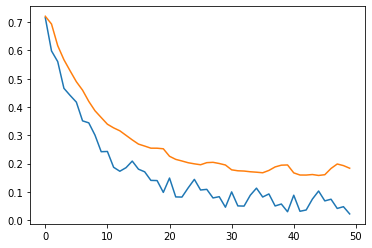

In [27]:
W,b,A = train([n,6000,2000,1000,500,100,20,1],X_train,Y_train,0.01,5,100)

In [28]:
def modelp(X_train,Y_train,W,b) :
  strr = len(W) + 1
  n = X_train.shape[0]
  m = X_train.shape[1]
  A = {}
  A["A" + str(0)] = X_train
  for i in range(1,strr-1) :
    A["A" + str(i)] = forward_prop(A["A" + str(i-1)],W["W" + str(i)],b["b" + str(i)])
  A["A" + str(strr - 1)] = sigmoid(np.dot(W["W" + str(strr - 1)] , A["A" + str(strr - 2)]) + b["b" + str(strr - 1)])
  return A["A" + str(strr - 1)]
def pred(A,Y) :
  pred = np.zeros(A.shape)
  for i in range(0,A.shape[1]) :
    if A[0,i] >= 0.50 :
      pred[0,i] = 1
  fai = np.absolute(pred - Y)
  accuracy = 1 - (np.sum(fai)/Y.shape[1])
  return accuracy*100
A_train = modelp(X_train , Y_train ,W,b)
Acc_train = pred(A_train,Y_train)
print("Train accuracy is ", Acc_train)
A_val = modelp(X_val , Y_val ,W,b)
Acc_val = pred(A_val,Y_val)
print("Validation accuracy is ", Acc_val)
A_test = modelp(X_test , Y_test ,W,b)
Acc_test = pred(A_test,Y_test)
print("Test accuracy is ", Acc_test)

Train accuracy is  99.1
Validation accuracy is  94.33333333333334
Test accuracy is  93.33333333333333
